# Permutation importance & calibration

В данном ноутбуке проверяется модель на переобученность и избыточность фичей с помощью permutation importance и uplift.

Далее проверяется калибровка результата модели.

Вход: предобработанные паркеты, набор признаков и гиперпараметры

Выход: обученная модель, график uplift и калибровки

In [1]:
import setproctitle

setproctitle.setproctitle("alex_permutation")

In [28]:
import gc
import os
import sys
import time

import catboost
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm

tqdm.pandas()

In [3]:
samples = {
    k: pd.read_parquet(f"/home/asciishell/s3/jupyter.asciishell.ru/data_{k}.parquet") for k in ["train", "oos", "oot"]
}

In [12]:
features = [
    "inq_fi",
    "all_util",
    "home_ownership",
    "log_annual_inc",
    "annual_inc",
    "num_rev_tl_bal_gt_0",
    "mort_acc",
    "funded_amnt_inv",
    "emp_title",
    "bc_open_to_buy",
    "debt_load",
    "fico_range_low",
    "fico_range_high",
]

cat_features = [
    "emp_title",
    "home_ownership",
    "verification_status",
    "purpose",
    "zip_code",
    "addr_state",
    "initial_list_status",
    "application_type",
    "verification_status_joint",
    "disbursement_method",
]
cat_features = sorted(set(cat_features) & set(features))
params = {
    "iterations": 400,
    "depth": 6,
    "l2_leaf_reg": 24.337217538245532,
    "learning_rate": 0.14119449759028455,
    "random_strength": 1.284731588293853,
    "rsm": 0.5363370106196876,
    "grow_policy": "SymmetricTree",
    "od_wait": 50,
    "eval_metric": "AUC",
    "logging_level": "Silent",
}

In [13]:
pools = {
    k: catboost.Pool(v[v["target"] != -1][features], v[v["target"] != -1]["target"], cat_features=cat_features)
    for k, v in samples.items()
}
# pools['train'].quantize()
# pools['train'].save_quantization_borders('borders.dat')
# pools['oos'].quantize(input_borders='borders.dat')
# pools['oot'].quantize(input_borders='borders.dat')

# Train some model

In [14]:
clf = catboost.CatBoostClassifier(**params)
clf.fit(
    pools["train"],
    eval_set=pools["oos"],
    verbose=0,
    plot=True,
)
clf.save_model('catboost.cb')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# Uplift

In [15]:
# Перемешивание колонки для uplift
import contextlib


@contextlib.contextmanager
def column_shuffler(df, col, rs):
    orig = df[col].copy()
    df[col] = df[col].sample(frac=1, random_state=rs).values
    try:
        yield df
    finally:
        df[col] = orig

In [16]:
x = samples['oos'][samples['oos']['target'] != -1].copy()
imp = []
for i, f in enumerate(tqdm(features)):
    with column_shuffler(x, f, 42) as dfs:
        proba = clf.predict_proba(dfs[features])[:, 1]
        imp.append({
            'feature': f,
            'imp': roc_auc_score(dfs['target'], proba)
        })
imp = pd.DataFrame(imp).sort_values('imp').reset_index(drop=True)
imp

  0%|          | 0/13 [00:00<?, ?it/s]

,feature,imp
0,funded_amnt_inv,0.581098
1,debt_load,0.615717
2,log_annual_inc,0.646237
3,annual_inc,0.650658
4,emp_title,0.672509
5,fico_range_high,0.673130
6,num_rev_tl_bal_gt_0,0.675179
7,bc_open_to_buy,0.679087
8,mort_acc,0.680465
9,inq_fi,0.681429


In [17]:
uplift = []
for thr in tqdm(
    sorted(
        set(np.percentile(imp["imp"], np.linspace(0, 100, 20), interpolation="midpoint"))
        # | set(np.percentile(imp["imp"], np.linspace(0, 20, 20), interpolation="midpoint"))
        | set([imp["imp"].max()])
    )
):
    features2 = imp[imp["imp"] <= thr]["feature"].values.copy()
    pools2 = {
        k: catboost.Pool(
            v[v["target"] != -1][features2],
            v[v["target"] != -1]["target"],
            cat_features=sorted(set(features2) & set(cat_features)),
        )
        for k, v in samples.items()
    }
    clf_ = catboost.CatBoostClassifier(**params)
    clf_.fit(pools2["train"], eval_set=pools2["oos"], verbose=0, plot=False)

    x = samples["train"][samples["train"]["target"] != -1]
    proba = clf_.predict_proba(x[features2])[:, 1]
    mtrain = roc_auc_score(x["target"], proba)

    x = samples["oos"][samples["oos"]["target"] != -1]
    proba = clf_.predict_proba(x[features2])[:, 1]
    moos = roc_auc_score(x["target"], proba)

    x = samples["oot"][samples["oot"]["target"] != -1]
    proba = clf_.predict_proba(x[features2])[:, 1]
    moot = roc_auc_score(x["target"], proba)

    uplift.append(
        {
            "columns": len(features2),
            "features": features2,
            "train_score": mtrain,
            "oos_score": moos,
            "oot_score": moot,
        }
    )
uplift = pd.DataFrame(uplift)
uplift

  0%|          | 0/14 [00:00<?, ?it/s]

,columns,features,train_score,oos_score,oot_score
0,1,[funded_amnt_inv],0.564480,0.563185,0.573444
1,1,[funded_amnt_inv],0.564480,0.563185,0.573444
2,2,"[funded_amnt_inv, debt_load]",0.595803,0.592391,0.615834
3,3,"[funded_amnt_inv, debt_load, log_annual_inc]",0.631642,0.624128,0.617521
4,4,"[funded_amnt_inv, debt_load, log_annual_inc, a...",0.634148,0.625900,0.618848
5,5,"[funded_amnt_inv, debt_load, log_annual_inc, a...",0.725748,0.638292,0.630969
6,6,"[funded_amnt_inv, debt_load, log_annual_inc, a...",0.738317,0.667383,0.661224
7,7,"[funded_amnt_inv, debt_load, log_annual_inc, a...",0.735266,0.671311,0.666311
8,8,"[funded_amnt_inv, debt_load, log_annual_inc, a...",0.735583,0.672773,0.669827
9,9,"[funded_amnt_inv, debt_load, log_annual_inc, a...",0.740292,0.678270,0.681668


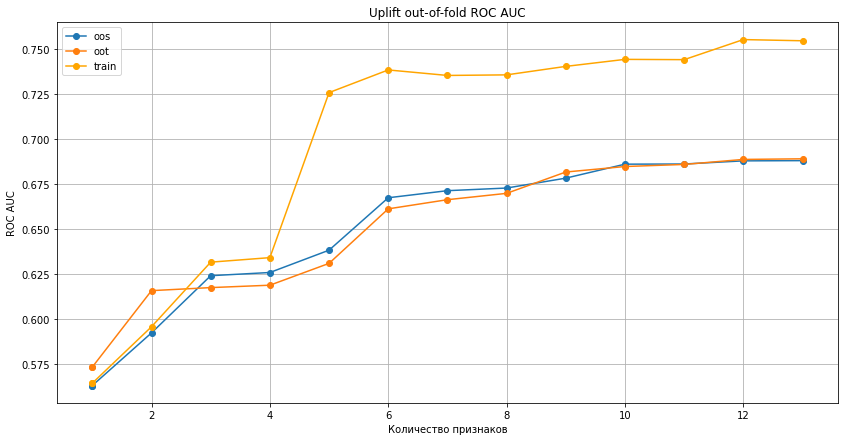

In [18]:
plt.figure(figsize=(14, 7), facecolor='w')
plt.plot(uplift['columns'], uplift['oos_score'], marker='o', label='oos')
plt.plot(uplift['columns'], uplift['oot_score'], marker='o', label='oot')
plt.plot(uplift['columns'], uplift['train_score'], marker='o', color='orange', label='train')

plt.title('Uplift out-of-fold ROC AUC')
plt.legend()
plt.xlabel('Количество признаков')
plt.ylabel('ROC AUC')
# plt.twinx()
plt.grid()

# Калибровка

In [32]:
clf = catboost.CatBoostClassifier(**params)
clf.load_model('catboost.cb')

In [53]:
calibration_res =[]
for k, v in samples.items():
    s = v[v["target"] != -1]
    y_true = s['target'].values
    y_score = clf.predict_proba(s[features])[:, 1]
    
    lb, ub = [x / len(s) for x in ss.binom.interval(n=len(s), p=y_score.mean(), alpha=0.95)]
    calibration_res.append({
        'sample': k,
        'TR': y_true.mean(),
        'SR': y_score.mean(),
        'LB': lb,
        'UB': ub,
        'OK': lb <=  y_true.mean() <= ub,
    })
calibration_res = pd.DataFrame(calibration_res)
calibration_res

,sample,TR,SR,LB,UB,OK
0,train,0.198634,0.199022,0.198140,0.199904,True
1,oos,0.199663,0.198801,0.197454,0.200149,True
2,oot,0.235284,0.222947,0.221256,0.224640,False


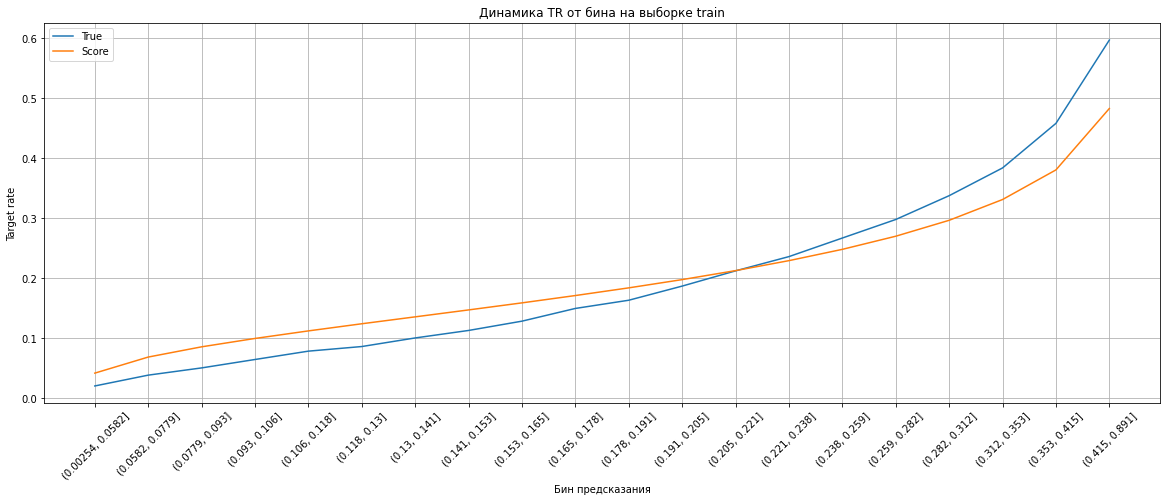

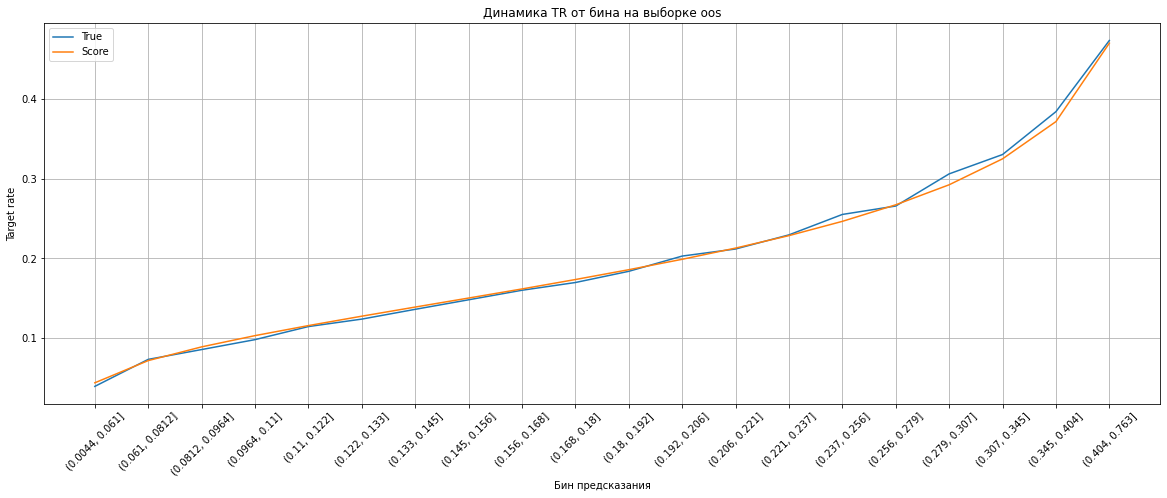

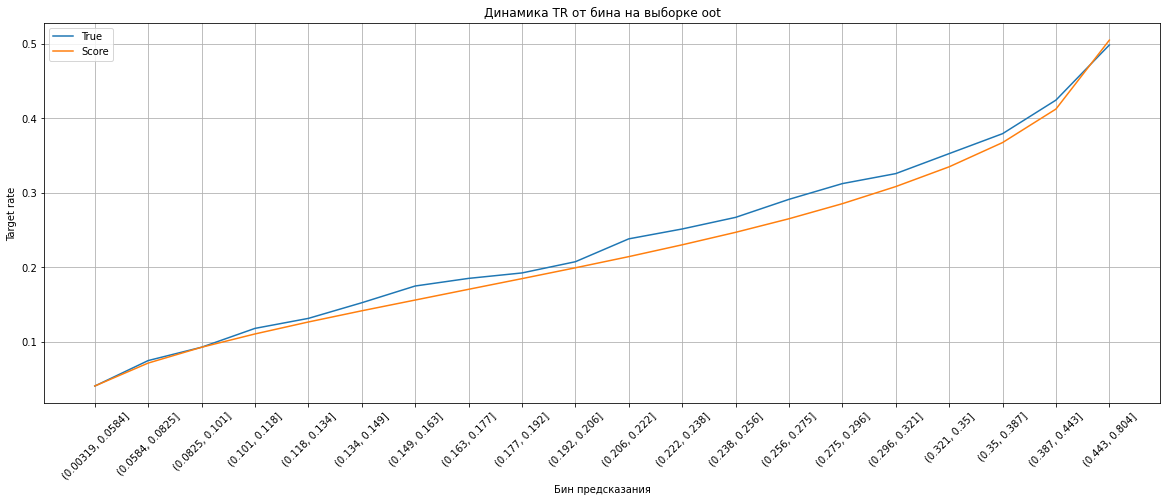

In [34]:
for k, v in samples.items():
    x = v[v["target"] != -1]
    y_true = x['target'].values
    y_score = clf.predict_proba(x[features])[:, 1]
    data = pd.DataFrame({'true': y_true, 'score': y_score})
    x = data.assign(q=pd.qcut(data['score'], q=20, duplicates='drop')).groupby('q').agg('mean')
    xi = np.arange(len(x))
    plt.figure(figsize=(20, 7), facecolor='w')
    plt.plot(xi, x['true'].values, label='True')
    plt.plot(xi, x['score'].values, label='Score')
    plt.xticks(xi, x.index, rotation=45)

    plt.xlabel('Бин предсказания')
    plt.ylabel('Target rate')
    plt.title(f'Динамика TR от бина на выборке {k}')
    plt.grid()
    plt.legend()
    plt.show()

# Feature gini

  0%|          | 0/13 [00:00<?, ?it/s]

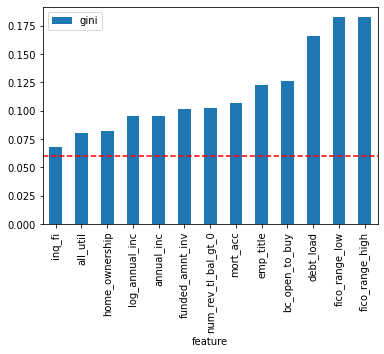

In [35]:
feature_gini = []

# x = samples["oos"][samples["oos"]["target"] != -1]
for f in tqdm(features):
    clf_ = catboost.CatBoostClassifier(iterations=50, depth=1, eval_metric='AUC', ignored_features=sorted(set(features) - {f}))
    clf_.fit(
        pools["train"],
        eval_set=pools["oos"],
        verbose=0,
        # plot=True,
    )
    # metric = roc_auc_score(x['target'], clf.predict_proba(pools['oos'])[:, 1])
    metric = clf_.best_score_['validation']['AUC']
    feature_gini.append({
        'feature': f,
        'gini': metric * 2 - 1,
    })
feature_gini = pd.DataFrame(feature_gini).sort_values('gini')
feature_gini.plot.bar(x='feature')
plt.axhline(0.06, linestyle='--', color='r')

# Shap

In [ ]:
import shap
shap.initjs()

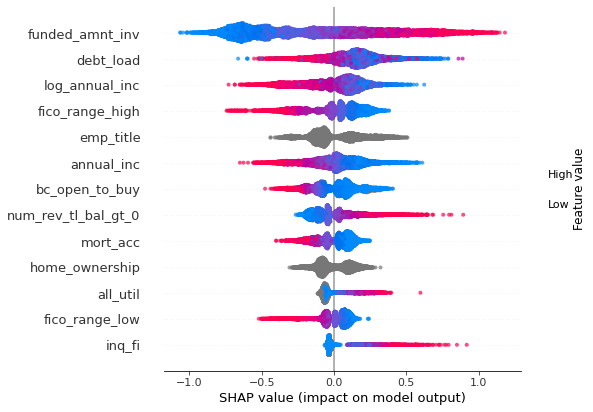

In [36]:
X = samples["oos"][samples["oos"]["target"] != -1][clf.feature_names_].sample(10_000, random_state=42).copy()

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, max_display=20, alpha=0.7)